<a href="https://colab.research.google.com/github/PederRonning/sok-3023/blob/main/shipping_forecast_template_gooood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shipping Index Forecasting with SARIMAX and LSTM  
Denne notatboken er en **komplett mal** som oppfyller kravene i obligatorisk oppgave (Søk 3023).  
Tekstdelene er korte plassholdere – fyll ut egen problemformulering og refleksjon før levering.

> **Datasett som brukes**  
> * `OSLO Shipping Historical Data.csv`  
> * `Crude Oil WTI Futures Historical Data.csv`  

Plasser begge CSV‑filene i samme mappe som denne `.ipynb`‑filen før du kjører koden.

In [15]:
# Installere eventuell ekstern pakke (pmdarima) – ignorerer hvis den finnes
# Standard imports
import random, os, math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, optimizers

# Reproduserbarhet
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 1  Dataset og problemstilling

In [16]:
# Les inn shipping‑indeks og oljepris
shipping_csv = "OSLO Shipping Historical Data.csv"
oil_csv      = "Crude Oil WTI Futures Historical Data.csv"

df  = pd.read_csv(shipping_csv)
oil = pd.read_csv(oil_csv)

for d in (df, oil):
    d['Date']  = pd.to_datetime(d['Date'], format='%m/%d/%Y')
    d['Price'] = (d['Price'].astype(str)
                            .str.replace(',', '', regex=False)
                            .astype(float))

df  = df.rename(columns={'Price': 'ShipPrice'})
oil = oil.rename(columns={'Price': 'OilPrice'})

merged = (pd.merge(df, oil, on='Date', how='inner')
            .sort_values('Date')
            .reset_index(drop=True))

merged.head()


,Date,ShipPrice,Open_x,High_x,Low_x,Vol._x,Change %_x,OilPrice,Open_y,High_y,Low_y,Vol._y,Change %_y
0,2020-01-08,223.10,222.60,224.40,222.03,NaN,0.24%,59.46,62.63,65.40,58.99,436.61K,-4.88%
1,2020-01-09,224.37,223.52,225.16,223.04,NaN,0.57%,59.44,59.85,60.17,58.55,268.85K,-0.03%
2,2020-01-10,225.60,224.37,227.36,224.27,NaN,0.55%,58.99,59.51,59.67,58.79,256.06K,-0.76%
3,2020-01-13,225.23,225.60,226.93,224.47,NaN,-0.16%,58.08,59.08,59.21,57.93,295.82K,-1.54%
4,2020-01-14,223.28,225.19,226.29,222.79,NaN,-0.87%,58.26,58.06,58.73,57.74,262.79K,0.31%


## 2  Dataforståelse og preprosessering

In [17]:
# Enkel utforskning
print(merged.describe())

# Konverter til tidsserie med business‑day frekvens
merged = merged.set_index('Date').asfreq('B')
merged = merged.ffill()    # fyll evt. hull

# Skaler prisene [0,1] for LSTM
scaler = MinMaxScaler()
merged[['ShipPrice_scaled', 'OilPrice_scaled']] = scaler.fit_transform(
    merged[['ShipPrice', 'OilPrice']]
)
merged.head()


                                Date    ShipPrice     OilPrice       Open_y  \
count                           1291  1291.000000  1291.000000  1291.000000   
mean   2022-07-30 21:43:55.166537728   458.083950    70.857816    70.874012   
min              2020-01-08 00:00:00   122.180000    11.570000    18.010000   
25%              2021-04-21 12:00:00   223.125000    63.565000    63.620000   
50%              2022-08-02 00:00:00   394.740000    73.420000    73.600000   
75%              2023-11-07 12:00:00   703.715000    81.030000    81.000000   
max              2025-02-26 00:00:00  1028.350000   119.780000   120.660000   
std                              NaN   269.789889    18.828727    18.830305   

            High_y        Low_y  
count  1291.000000  1291.000000  
mean     72.112006    69.558954  
min      19.660000     6.500000  
25%      64.855000    62.575000  
50%      74.720000    72.460000  
75%      82.040000    80.040000  
max     126.420000   118.520000  
std      19.1253

,ShipPrice,Open_x,High_x,Low_x,Vol._x,Change %_x,OilPrice,Open_y,High_y,Low_y,Vol._y,Change %_y,ShipPrice_scaled,OilPrice_scaled
Date,,,,,,,,,,,,,,
2020-01-08,223.10,222.60,224.40,222.03,NaN,0.24%,59.46,62.63,65.40,58.99,436.61K,-4.88%,0.111370,0.442565
2020-01-09,224.37,223.52,225.16,223.04,NaN,0.57%,59.44,59.85,60.17,58.55,268.85K,-0.03%,0.112771,0.442381
2020-01-10,225.60,224.37,227.36,224.27,NaN,0.55%,58.99,59.51,59.67,58.79,256.06K,-0.76%,0.114129,0.438222
2020-01-13,225.23,225.60,226.93,224.47,NaN,-0.16%,58.08,59.08,59.21,57.93,295.82K,-1.54%,0.113720,0.429812
2020-01-14,223.28,225.19,226.29,222.79,NaN,-0.87%,58.26,58.06,58.73,57.74,262.79K,0.31%,0.111568,0.431476


### Vindugenerering for LSTM

In [18]:
def df_to_windowed(df, lookback=3, target_col='ShipPrice_scaled'):
    """Returnerer X, y, dates for valgt target‑kolonne"""
    X, y, dates = [], [], []
    for i in range(len(df) - lookback):
        window = df.iloc[i : i + lookback]
        X.append(window[['ShipPrice_scaled', 'OilPrice_scaled']].values)
        y.append(df[target_col].iloc[i + lookback])
        dates.append(df.index[i + lookback])
    return np.array(X), np.array(y), np.array(dates)

LOOKBACK = 3
X, y, dates = df_to_windowed(merged, LOOKBACK)
print(f'X shape: {X.shape}, y shape: {y.shape}')


X shape: (1338, 3, 2), y shape: (1338,)


### Train / Val / Test‑split

In [19]:
q80 = int(len(dates) * .80)
q90 = int(len(dates) * .90)

dates_train, X_train, y_train = dates[:q80], X[:q80], y[:q80]
dates_val,   X_val,   y_val   = dates[q80:q90], X[q80:q90], y[q80:q90]
dates_test,  X_test,  y_test  = dates[q90:],    X[q90:],    y[q90:]

print(f'Train: {X_train.shape},  Val: {X_val.shape},  Test: {X_test.shape}')


Train: (1070, 3, 2),  Val: (134, 3, 2),  Test: (134, 3, 2)


## 3  Modell 1 — SARIMAX

In [20]:
# --- SARIMAX trenes KUN på data t.o.m. 2023-12-31 --------------------
sarimax_train_end = "2023-12-31"

sarimax_y_train  = merged['ShipPrice'].loc[:sarimax_train_end]
sarimax_exo_train = merged['OilPrice'].loc[:sarimax_train_end]

sarimax_model = SARIMAX(
    sarimax_y_train,
    exog=sarimax_exo_train,
    order=(0,1,0),
    seasonal_order=(1,0,1,5)
)
sarimax_fitted = sarimax_model.fit()
print(sarimax_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           ShipPrice   No. Observations:                 1038
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 5)   Log Likelihood               -3305.889
Date:                             Tue, 29 Apr 2025   AIC                           6619.778
Time:                                     12:03:38   BIC                           6639.554
Sample:                                 01-08-2020   HQIC                          6627.281
                                      - 12-29-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OilPrice       0.5219      0.070      7.412      0.000       0.384       0.660
ar.S.L5       -0.6547      

In [21]:
# --- Forecast fra 2024-01-02 til slutten av datasettet ---------------
sarimax_pred_start = "2024-01-02"
sarimax_pred_end   = merged.index[-1]

sarimax_exo_pred = merged['OilPrice'].loc[sarimax_pred_start:sarimax_pred_end]

sarimax_fc = sarimax_fitted.get_forecast(
    steps=len(sarimax_exo_pred),
    exog=sarimax_exo_pred
)

sarimax_pred  = sarimax_fc.predicted_mean
sarimax_truth = merged['ShipPrice'].loc[sarimax_pred_start:sarimax_pred_end]

## 4  Modell 2 — LSTM

In [22]:
lstm_model = models.Sequential([
    layers.Input((LOOKBACK, 2)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(
    loss='mse',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['mae']
)

early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[early],
    verbose=0   # skrur av spam
)


In [23]:
# Prediksjon på testsett
lstm_pred_scaled = lstm_model.predict(X_test).flatten()

# Inverter skalering til original enhet
lstm_pred = scaler.inverse_transform(
    np.column_stack([
        lstm_pred_scaled,                     # ShipPrice_scaled
        merged['OilPrice_scaled'].iloc[-len(lstm_pred_scaled):]
    ])
)[:,0]

lstm_truth = merged['ShipPrice'].iloc[-len(lstm_pred):]

lstm_mse  = mean_squared_error(lstm_truth, lstm_pred)
lstm_rmse = math.sqrt(lstm_mse)
lstm_mae  = mean_absolute_error(lstm_truth, lstm_pred)

print(f"LSTM – RMSE: {lstm_rmse:.2f}  MAE: {lstm_mae:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
LSTM – RMSE: 26.47  MAE: 20.92


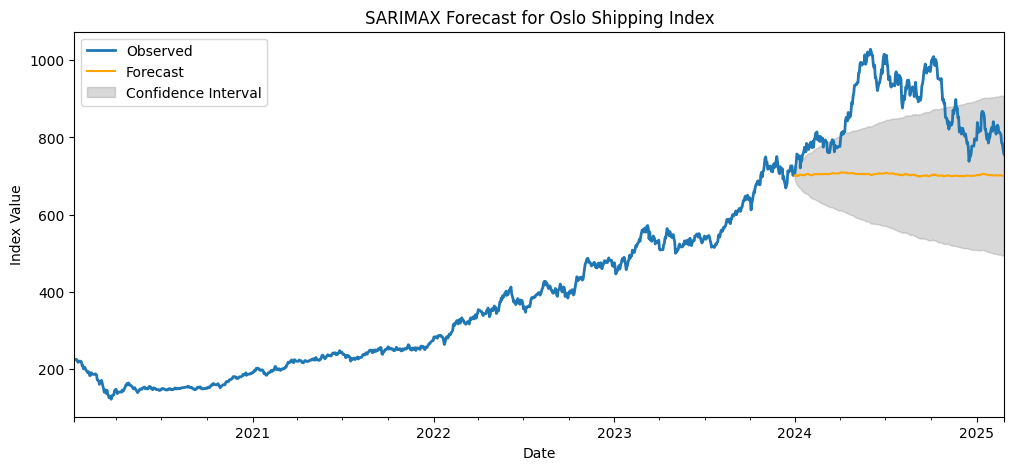

In [24]:
# --- Plot SARIMAX forecast with confidence interval -----------------
fig, ax = plt.subplots(figsize=(12, 5))

# Hele observasjonsperioden
y_series = merged['ShipPrice']      # alias til hele tidsserien
y_series.plot(ax=ax, label='Observed', linewidth=2)

# Forecast (samme lengde som sarimax_pred)
sarimax_pred.plot(ax=ax, label='Forecast', color='orange')

# Konfidensintervall fra statsmodels
ci = sarimax_fc.conf_int()
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1],
                color='gray', alpha=0.3, label='Confidence Interval')

ax.set_title('SARIMAX Forecast for Oslo Shipping Index')
ax.set_xlabel('Date')
ax.set_ylabel('Index Value')
ax.legend()
plt.show()

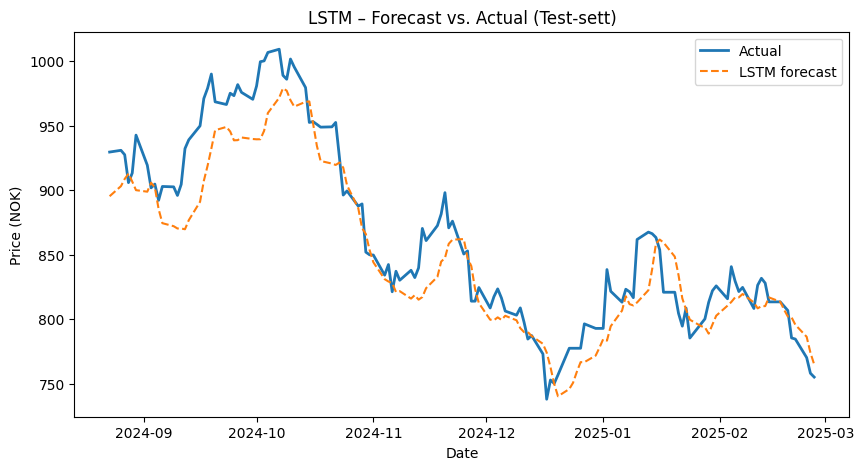

In [25]:
# --- Plot LSTM predictions vs. actual on test‑sett ------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates_test, lstm_truth.values, label='Actual', linewidth=2)
ax.plot(dates_test, lstm_pred, label='LSTM forecast', linestyle='--')
ax.set_title('LSTM – Forecast vs. Actual (Test‑sett)')
ax.set_xlabel('Date')
ax.set_ylabel('Price (NOK)')
ax.legend()
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


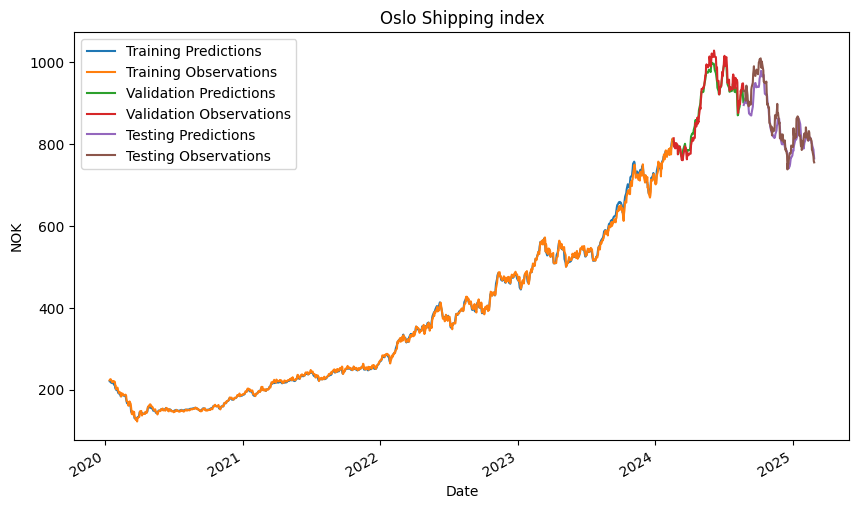

In [26]:
# ---------------------------------------------------------------
# Sammensatt plot: Training / Validation / Testing (LSTM)
# ---------------------------------------------------------------
# 1) Hent/skaler tilbake LSTM-prediksjonene
train_pred_scaled = lstm_model.predict(X_train).flatten()
val_pred_scaled   = lstm_model.predict(X_val).flatten()
test_pred_scaled  = lstm_model.predict(X_test).flatten()

def invert_scale(pred_scaled, oil_scaled_slice):
    """Inverse-transform ShipPrice using samme scaler som tidligere."""
    return scaler.inverse_transform(
        np.column_stack([pred_scaled, oil_scaled_slice])
    )[:, 0]

train_pred = invert_scale(train_pred_scaled,
                          merged['OilPrice_scaled'].iloc[:len(train_pred_scaled)])
val_pred   = invert_scale(val_pred_scaled,
                          merged['OilPrice_scaled'].iloc[len(train_pred_scaled):
                                                         len(train_pred_scaled)+len(val_pred_scaled)])
test_pred  = invert_scale(test_pred_scaled,
                          merged['OilPrice_scaled'].iloc[-len(test_pred_scaled):])

# 2) Hent tilsvarende observerte verdier
train_obs = merged['ShipPrice'].iloc[:len(train_pred)]
val_obs   = merged['ShipPrice'].iloc[len(train_pred):
                                     len(train_pred)+len(val_pred)]
test_obs  = merged['ShipPrice'].iloc[-len(test_pred):]

# 3) Plot
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_pred, label='Training Predictions')
plt.plot(dates_train, train_obs,  label='Training Observations')

plt.plot(dates_val,   val_pred,   label='Validation Predictions')
plt.plot(dates_val,   val_obs,    label='Validation Observations')

plt.plot(dates_test,  test_pred,  label='Testing Predictions')
plt.plot(dates_test,  test_obs,   label='Testing Observations')

plt.title('Oslo Shipping index')
plt.xlabel('Date')
plt.ylabel('NOK')
plt.legend()
plt.gcf().autofmt_xdate()   # roter datoetiketter pent
plt.show()

## 5  Konklusjon og refleksjon  
*Fyll inn: drøft hvilken modell som presterte best og hvorfor, potensielle forbedringer, og implikasjoner i praksis.*